# Task 2 Optimization of the Investment Portfolio

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.optimize import minimize

### 2.1 Weights Based on Volatility

In [2]:
# Define the list of stocks and the date range for analysis
stock_list = ['AAPL', 'GOOGL', 'META', 'AMD',  'MSFT']
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=1200)

# Use yfinance to download stock data in bulk
data = yf.download(stock_list, start=start_date, end=end_date)

# Risk-Free Rate Calculation
tnx = yf.Ticker("^IRX")
tnx_data = tnx.history(period="1mo")
risk_free_rate = tnx_data['Close'].mean() / 100  # Convert to percentage
print(f"The average risk-free rate over the past month is: {risk_free_rate}")

# Volatility Calculation
daily_returns = data['Adj Close'].pct_change()
volatility = daily_returns.std() * np.sqrt(252)

[*********************100%%**********************]  5 of 5 completed

The average risk-free rate over the past month is: 0.05227238087427048


In [3]:
# Calculate the inverse of the volatility as the basis for the weights
inverse_volatility = 1 / volatility

# Normalize the weights so that they sum up to 1
weights = inverse_volatility / inverse_volatility.sum()

# Remove S&P 500 from daily_returns if it's included
if 'S&P 500' in daily_returns.columns:
    daily_returns = daily_returns.drop('S&P 500', axis=1)

# Calculate portfolio's daily returns
portfolio_daily_returns = daily_returns.dot(weights)

confidence_level = 0.05  # 95% confidence level

# Calculate VaR
VaR = portfolio_daily_returns.quantile(confidence_level)
print(f"Value at Risk (95% confidence): {VaR:.2%}")

# Calculate CVaR
CVaR = portfolio_daily_returns[portfolio_daily_returns <= VaR].mean()
print(f"Conditional Value at Risk (95% confidence): {CVaR:.2%}")


Value at Risk (95% confidence): -2.90%
Conditional Value at Risk (95% confidence): -3.89%


### 2.2 Risk Measurement with Monte Carlo Simulation

In [4]:
n_days = 500  # Number of days to simulate
n_simulations = 1000  # Number of simulation runs
initial_investment = 100000  # Initial investment amount

# Mean and covariance of daily returns
daily_returns_mean = daily_returns.mean().values
daily_returns_cov = daily_returns.cov().values

# Preallocate an array to store simulation results
simulation_results = np.zeros((n_simulations, n_days))

for i in range(n_simulations):
    # Generate random daily returns
    daily_random_returns = np.random.multivariate_normal(daily_returns_mean, daily_returns_cov, n_days)
    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + daily_random_returns.dot(weights), axis=0)
    # Calculate portfolio value
    simulation_results[i] = initial_investment * cumulative_returns

# Calculate and print the mean final value, VaR, and CVaR of the simulations
final_values = simulation_results[:, -1]
mean_final_value = final_values.mean()
VaR_95 = np.percentile(final_values, 5)
CVaR_95 = final_values[final_values <= VaR_95].mean()

print(f"Mean Final Value: ${mean_final_value:,.2f}")
print(f"95% VaR: ${VaR_95:,.2f}")
print(f"95% CVaR: ${CVaR_95:,.2f}")


Mean Final Value: $159,586.40
95% VaR: $78,516.49
95% CVaR: $66,723.22


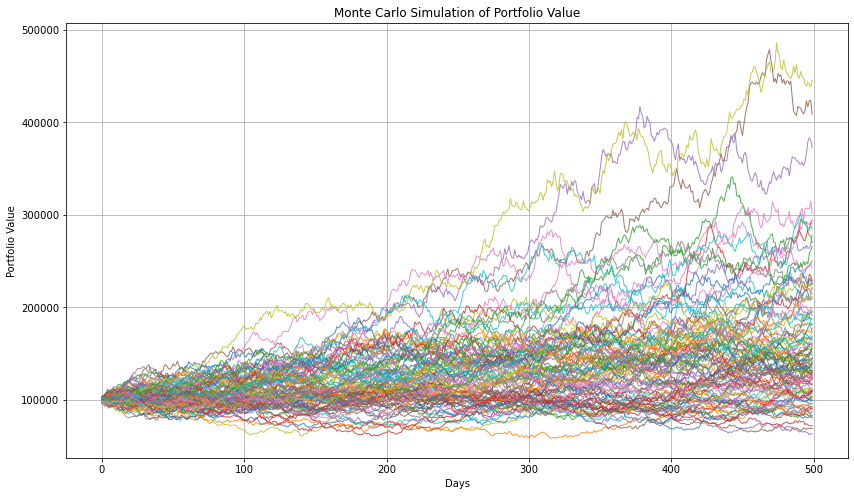

In [5]:
n_display_simulations = 100  # Display only 100 paths for clarity

plt.figure(figsize=(14, 8))
for i in range(min(n_display_simulations, n_simulations)):
    plt.plot(simulation_results[i], lw=1, alpha=0.8)

plt.title("Monte Carlo Simulation of Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


### 2.3 Mean-Variance Optimization

In [6]:
covariance_matrix = daily_returns.cov()
covariance_matrix

Ticker,AAPL,AMD,GOOGL,META,MSFT
Ticker,,,,,
AAPL,0.000297,0.000305,0.000223,0.000266,0.000209
AMD,0.000305,0.001024,0.000353,0.000470,0.000330
GOOGL,0.000223,0.000353,0.000389,0.000358,0.000243
META,0.000266,0.000470,0.000358,0.000878,0.000292
MSFT,0.000209,0.000330,0.000243,0.000292,0.000293


In [7]:
num_assets = len(daily_returns.columns)
initial_weights = np.ones(num_assets) / num_assets

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))

def negative_sharpe_ratio(weights, returns, covariance, risk_free_rate):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(covariance, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

opt_results = minimize(
    negative_sharpe_ratio, initial_weights,
    args=(daily_returns.mean()*252, covariance_matrix*252, risk_free_rate),
    method='SLSQP', bounds=bounds, constraints=constraints
)
optimal_weights = opt_results.x
print("Optimal Weights:\n", optimal_weights)

optimal_portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))

print("Optimal Portfolio Volatility:", optimal_portfolio_volatility)

portfolio_df = pd.DataFrame({
    'Stock': stock_list,
    'Optimal Weight (%)': [round(weight * 100, 2) for weight in optimal_weights]
})

print(portfolio_df)

Optimal Weights:
 [1.92008501e-16 7.78328967e-02 1.17594252e-17 6.91143772e-02
 8.53052726e-01]
Optimal Portfolio Volatility: 0.01752277868790425
   Stock  Optimal Weight (%)
0   AAPL                0.00
1  GOOGL                7.78
2   META                0.00
3    AMD                6.91
4   MSFT               85.31


### 2.4 Modern Portfolio Theory, MPT Optimization

Optimal Portfolio Composition:
AAPL: 1.46%
GOOGL: 7.06%
META: 5.48%
AMD: 13.26%
MSFT: 72.74%


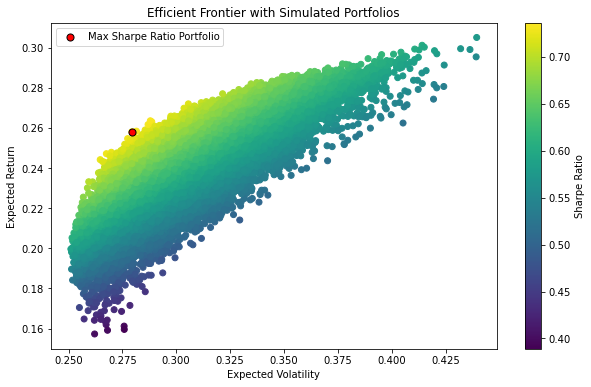

In [8]:
# Calculate annualized returns and annualized covariance matrix
returns_daily = data['Adj Close'][stock_list].pct_change()
returns_annual = returns_daily.mean() * 252
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# Initialize parameters
num_assets = len(stock_list)
num_portfolios = 50000
np.random.seed(42)

# Initialize lists to store information for simulated portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharp_ratios = []

# Simulate random portfolios
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize weights
    returns = np.dot(weights, returns_annual)  # Portfolio return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))  # Portfolio volatility
    sharpe = (returns - risk_free_rate) / volatility  # Sharpe ratio
    port_returns.append(returns)
    port_volatility.append(volatility)
    sharp_ratios.append(sharpe)
    stock_weights.append(weights)

# Identify the portfolio with the highest Sharpe ratio
max_sharpe_idx = np.argmax(sharp_ratios)
max_sharpe_return = port_returns[max_sharpe_idx]
max_sharpe_volatility = port_volatility[max_sharpe_idx]

# Get the weights of the portfolio with the highest Sharpe ratio
optimal_weights = stock_weights[max_sharpe_idx]

# Create a dictionary to store the stocks and their weights in the optimal portfolio
optimal_portfolio = {}

# Set a weight threshold to consider only stocks with a weight above this value
# For example, setting it to 0 includes only stocks with a weight greater than 0
weight_threshold = 0

for i, weight in enumerate(optimal_weights):
    if weight > weight_threshold:
        optimal_portfolio[stock_list[i]] = weight

# Print out the composition of the optimal portfolio
print("Optimal Portfolio Composition:")
for stock, weight in optimal_portfolio.items():
    print(f"{stock}: {weight*100:.2f}%")

# Plot all simulated portfolios
plt.figure(figsize=(10, 6))
plt.scatter(port_volatility, port_returns, c=sharp_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Simulated Portfolios')

# Highlight the portfolio with the highest Sharpe ratio
plt.scatter(max_sharpe_volatility, max_sharpe_return, c='red', s=50, edgecolors='black', label='Max Sharpe Ratio Portfolio')
plt.legend(labelspacing=0.8)

plt.show()


In [9]:
import pyfolio as pf

optimal_returns_daily = (returns_daily * optimal_weights).sum(axis=1)

optimal_returns_daily = optimal_returns_daily.dropna()

pf.create_full_tear_sheet(optimal_returns_daily)


/Users/hanyuyang/opt/anaconda3/envs/da/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Start date,2020-12-15
End date,2024-03-28
Total months,39
,Backtest
Annual return,24.4%
Cumulative returns,104.6%
Annual volatility,28.0%
Sharpe ratio,0.92
Calmar ratio,0.57
Stability,0.36
Max drawdown,-43.1%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'